In [165]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

In [166]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=1000,
                 noise=0.07,
                 random_state=RANDOM_SEED)

# X = torch.from_numpy(X).type(torch.float)
# y = torch.from_numpy(y).type(torch.float)

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=RANDOM_SEED)

In [167]:
# Turn data into a DataFrame
import pandas as pd

pd_data = pd.DataFrame({'x': X[:, 0],
                       'y': X[:, 1],
                       'label': y})

pd_data.head()

,x,y,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0


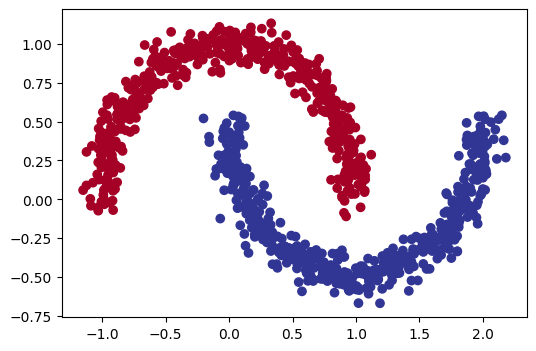

In [168]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(x=X[:, 0],
           y=X[:, 1],
           c=y,
           cmap=plt.cm.RdYlBu);

In [169]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [170]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers=10):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.layer_2 = nn.Linear(in_features=hidden_layers, out_features=hidden_layers)
        self.layer_3 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        # return self.layer_3(self.layer_2(self.layer_1(x)))

# Instantiate the model
model = MoonModelV0(input_features=2, output_features=1, hidden_layers=10).to(device)
model

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [171]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()
# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

## 4. Create a training and testing loop to fit the model we created in 2 to the data we created in 1.

In [172]:
# What's coming out of our model?
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

model.eval()
with torch.inference_mode():
    logits = model(X_train).squeeze()

# logits (raw outputs of model)
print("Logits:")
print(logits[:5])

# Prediction probabilities
print("Pred probs:")
pred_probs = torch.sigmoid(logits)
print(pred_probs[:5])

# Prediction labels
print("Pred labels:")
pred_labels = torch.round(pred_probs)
print(pred_labels[:5])
print(y_train[:5])

Logits:
tensor([0.2283, 0.1189, 0.1483, 0.1443, 0.1042], device='cuda:0')
Pred probs:
tensor([0.5568, 0.5297, 0.5370, 0.5360, 0.5260], device='cuda:0')
Pred labels:
tensor([1., 1., 1., 1., 1.], device='cuda:0')
tensor([1., 0., 0., 0., 1.], device='cuda:0')


In [ ]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
# pip install torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

In [174]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs + 1):
    ### Training
    model.train()
    # 1. Forward pass (logits output)
    y_logits = model(X_train).squeeze()
    # Turn logits into prediction probabilities
    pred_probs = torch.sigmoid(y_logits)
    # Turn prediction probabilities into prediction labels
    y_pred = torch.round(pred_probs)
    
    # 2. Calculaute the loss
    loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
    
    # Calculate the accuracy
    acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels
    
    # 3. Zero the gradients
    optimizer.zero_grad()
    
    # 4. Loss backward (perform backpropagation)
    loss.backward()
    # 5. Step the optimizer (gradient descent)
    optimizer.step()
    
    ### Testing
    model.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        y_logits = model(X_test).squeeze()
        # Turn the test logits into prediction labels
        test_pred = torch.round(torch.sigmoid(y_logits))
        
        # 2. Caculate the test loss/acc
        test_loss = loss_fn(test_pred, y_test)
        test_acc = acc_fn(test_pred, y_test.int())
        
        # Print out what's happening every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
        

Epoch: 0 | Loss: 0.6955 | Acc: 0.50% | Test Loss: 0.8133 | Test Acc: 0.50%
Epoch: 100 | Loss: 0.3757 | Acc: 0.83% | Test Loss: 0.5989 | Test Acc: 0.81%
Epoch: 200 | Loss: 0.2421 | Acc: 0.88% | Test Loss: 0.5630 | Test Acc: 0.89%
Epoch: 300 | Loss: 0.2133 | Acc: 0.91% | Test Loss: 0.5549 | Test Acc: 0.90%
Epoch: 400 | Loss: 0.1901 | Acc: 0.92% | Test Loss: 0.5568 | Test Acc: 0.90%
Epoch: 500 | Loss: 0.1624 | Acc: 0.93% | Test Loss: 0.5506 | Test Acc: 0.91%
Epoch: 600 | Loss: 0.1295 | Acc: 0.94% | Test Loss: 0.5318 | Test Acc: 0.95%
Epoch: 700 | Loss: 0.0956 | Acc: 0.96% | Test Loss: 0.5175 | Test Acc: 0.98%
Epoch: 800 | Loss: 0.0673 | Acc: 0.98% | Test Loss: 0.5113 | Test Acc: 0.99%
Epoch: 900 | Loss: 0.0476 | Acc: 0.99% | Test Loss: 0.5032 | Test Acc: 1.00%
Epoch: 1000 | Loss: 0.0349 | Acc: 1.00% | Test Loss: 0.5032 | Test Acc: 1.00%


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [175]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

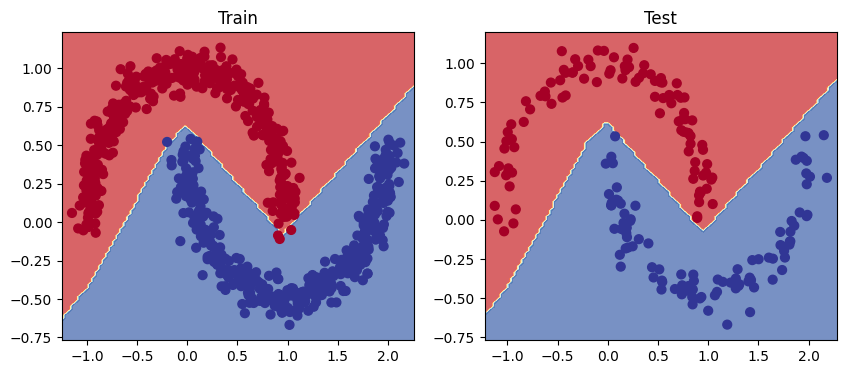

In [176]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

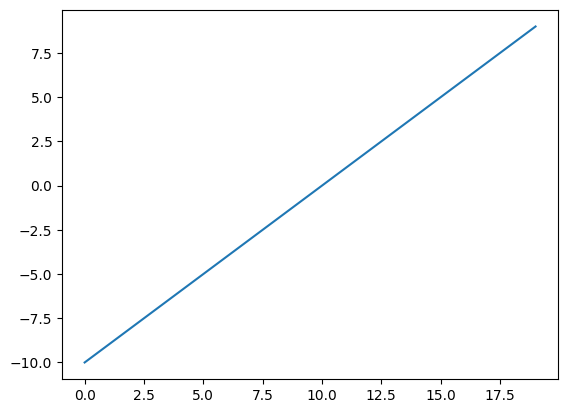

In [177]:
# Create a straight line tensor
A = torch.arange(-10, 10, 1).type(torch.float)
plt.plot(A)

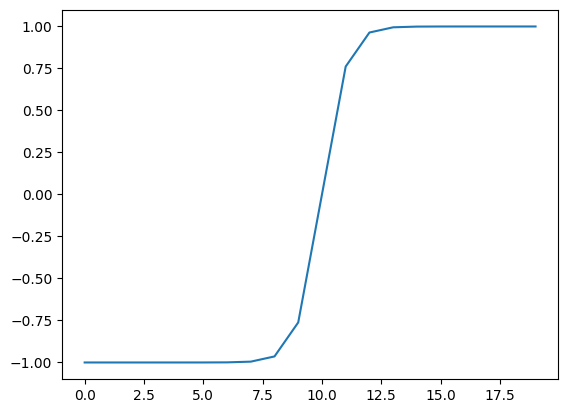

In [178]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(A))

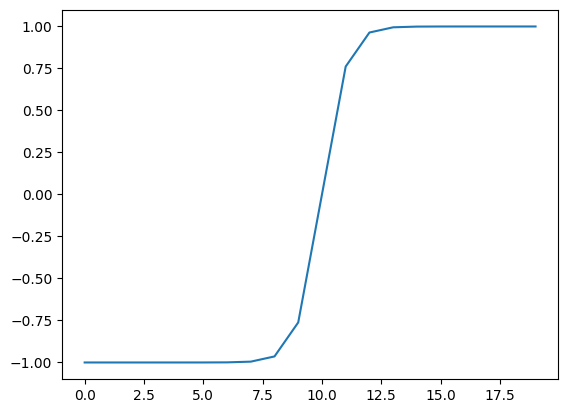

In [179]:
# Replicate torch.tanh() and plot it

def c_tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

plt.plot(c_tanh(A));

## 7. Creating a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).

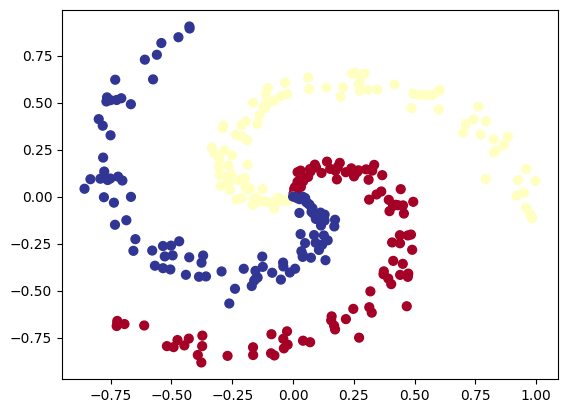

In [180]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [181]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [182]:
# Let's calculuate the accuracy for when we fit our model
# pip install torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [183]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_layers=10):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_layers)
        self.layer2 = nn.Linear(in_features=hidden_layers, out_features=hidden_layers)
        self.layer3 = nn.Linear(in_features=hidden_layers, out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

# Instantiate model and send it to device
model = SpiralModel(input_features=2, output_features=3, hidden_layers=10).to(device)
model

SpiralModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [184]:
# Setup data to be device agnostic
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
model.eval()
with torch.inference_mode():
    logits = model(X_train)

print("Logits:")
print(logits[:5])

print("Pred probs:")
print(torch.softmax(model(X_train), dim=1)[:5])

print("Pred labels:")
print(torch.softmax(model(X_train), dim=1).argmax(dim=1)[:5])

Logits:
tensor([[-0.2160, -0.0600,  0.2256],
        [-0.2020, -0.0530,  0.2257],
        [-0.2223, -0.0604,  0.2384],
        [-0.2174, -0.0555,  0.2826],
        [-0.2201, -0.0502,  0.2792]], device='cuda:0')
Pred probs:
tensor([[0.2685, 0.3139, 0.4176],
        [0.2707, 0.3142, 0.4151],
        [0.2659, 0.3126, 0.4215],
        [0.2615, 0.3074, 0.4311],
        [0.2609, 0.3092, 0.4299]], device='cuda:0', grad_fn=<SliceBackward0>)
Pred labels:
tensor([2, 2, 2, 2, 2], device='cuda:0')


In [185]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

In [186]:
# Building a training loop for the model
epochs = 1000
# Loop over data
for epoch in range(epochs + 1):
    ## Training
    model.train()
    # 1. Forward pass
    y_logits = model(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ## Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Caculate loss and acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test)
    
        # Print out what's happening every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {100 * acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {100* test_acc:.2f}%")

Epoch: 0 | Loss: 1.1175 | Acc: 32.50% | Test Loss: 1.0933 | Test Acc: 33.33%
Epoch: 100 | Loss: 0.0570 | Acc: 98.33% | Test Loss: 0.0590 | Test Acc: 96.67%
Epoch: 200 | Loss: 0.0528 | Acc: 98.33% | Test Loss: 0.0393 | Test Acc: 96.67%
Epoch: 300 | Loss: 0.0445 | Acc: 98.33% | Test Loss: 0.0390 | Test Acc: 96.67%
Epoch: 400 | Loss: 0.0416 | Acc: 98.33% | Test Loss: 0.0383 | Test Acc: 96.67%
Epoch: 500 | Loss: 0.0395 | Acc: 98.33% | Test Loss: 0.0402 | Test Acc: 96.67%
Epoch: 600 | Loss: 0.0380 | Acc: 98.33% | Test Loss: 0.0393 | Test Acc: 96.67%
Epoch: 700 | Loss: 0.0367 | Acc: 98.33% | Test Loss: 0.0341 | Test Acc: 96.67%
Epoch: 800 | Loss: 0.0359 | Acc: 98.33% | Test Loss: 0.0383 | Test Acc: 96.67%
Epoch: 900 | Loss: 0.0349 | Acc: 98.33% | Test Loss: 0.0385 | Test Acc: 96.67%
Epoch: 1000 | Loss: 0.0345 | Acc: 98.33% | Test Loss: 0.0248 | Test Acc: 98.33%


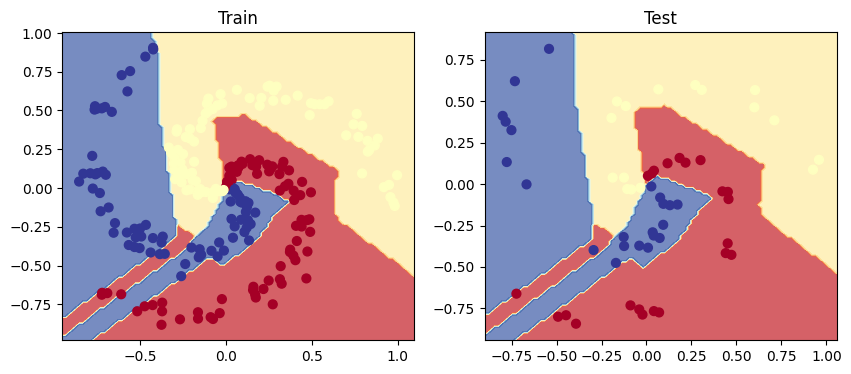

In [187]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)